<a href="https://colab.research.google.com/github/spinillac11/DeepLearning/blob/main/DL2A_fashion_mnist_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion-MNIST dataset & Feed-Forward Neural Networks with PyTorch

***

# Foreword
This notebook serves as **a template** for your experiments and explorations. You are encouraged not only to write the necessary code to complete the assigned tasks but also **to document your work clearly**. This includes **adding Markdown cells with your explanations, conclusions, and figures**. *The goal is for you to make this notebook into a nice report!*

Here are **a few key points** to keep in mind:

- Make sure you understand the code you write.

- Clearly explain your results and observations.

- Write clean, well-documented code.

- Avoid copy-pasting the same code multiple times — instead, define reusable functions!

# Main Objective: Image Classification

This lab introduces **feed-forward neural networks using PyTorch**, with a focus on **image classification**. You’ll work with the Fashion-MNIST dataset (see [Fashion-MNIST GitHub](https://github.com/zalandoresearch/fashion-mnist) for more details), which consists of:
- 60,000 training images
- 10,000 testing images
- Each image is 28×28 pixels, totaling 784 features per image
- The images are flattened into vectors of length 784 before being passed to the network

During this session, you’ll build and train several feed-forward models, starting with simple architectures and gradually increasing their complexity.

*!! First load and test Python and PyTorch. Your notebook is supposed to work with Python 3 (see the top right corner of the notebook).*


In [ ]:
import torch as th
import torch.nn as nn
import numpy as np
import pickle
import math, gzip
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats=['svg']
%config InlineBackend.figure_format = 'svg'
print(th.__version__) # should be greater or equal to 1.0


2.8.0+cu126


# Dataset

As already mentioned, we will use the Fashion-MNIST dataset for image classification. You can download it via torchvision, but, for simplicity, a preprocessed pickle file can be dowloaded using the link below.


## Download the dataset

**If you are using Colab --- prefered option**

In [ ]:
import gdown
url = 'https://drive.google.com/uc?id=1qx-a3KjzX2W66Aq84tnjGRUa10CTxOJN'
output = 'fashion-mnist.pk.gz'
gdown.download(url, output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1qx-a3KjzX2W66Aq84tnjGRUa10CTxOJN
From (redirected): https://drive.google.com/uc?id=1qx-a3KjzX2W66Aq84tnjGRUa10CTxOJN&confirm=t&uuid=6bab8e41-4f24-4aa5-ba50-af6df93e199c
To: /content/fashion-mnist.pk.gz
100%|██████████| 44.6M/44.6M [00:00<00:00, 72.7MB/s]


'fashion-mnist.pk.gz'

If you are using Jupyter

In [ ]:
# To download the file with wget:
# ! wget -nc --no-check-certificate "https://drive.usercontent.google.com/download?id=1qx-a3KjzX2W66Aq84tnjGRUa10CTxOJN&confirm=t" -O "./fashion-mnist.pk.gz"

Check that the file has been downloaded (~43MB):

In [ ]:
! ls -lh ./fashion-mnist.pk.gz

-rw-r--r-- 1 root root 43M Apr  4  2025 ./fashion-mnist.pk.gz


### Load the Dataset

In [ ]:
fp = gzip.open('fashion-mnist.pk.gz','rb')
allXtrain, allYtrain, Xtest, Ytest, classlist  = pickle.load(fp)

**Important**: As mentioned before, the dataset is split in two parts, the training set and the test set. For thorough study and evaluation of machine learning models, **a good practice is to actually split the data into 3 sets:**

- **Training set**: to learn model parameters
- **Validation set**: to tune the hyperparameters and some design choices (the number and the size of the hidden layers, the dropout probability, ...)
- **Test set**: to evaluate the final model.



### Training / validation sets

To **speed up** training during this lab, we'll use only the **first 20 000 samples for training** and take out another **10 000 for validation**.



In [ ]:
Xtrain, Ytrain  = allXtrain[:20000]/255, allYtrain[:20000]
Xvalid, Yvalid  = allXtrain[20000:30000]/255, allYtrain[20000:30000]
print("Training   shape:" ,Ytrain.shape)
print("Validation shape:" ,Yvalid.shape)

Training   shape: torch.Size([20000])
Validation shape: torch.Size([10000])


To better understand the data you are dealing with it is crucial to explore it! In this case this is the training set stored in the variables **Xtrain and Ytrain**.

- Look at the dimension and type of the tensors stored in these variables.
- Print the classlist variable.
- Look at some examples to check consistency.

For that purpose you can **visualize** training examples like this:

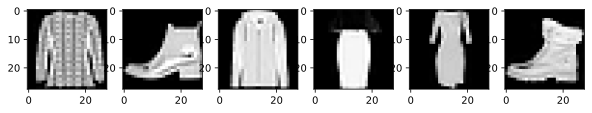

In [ ]:
indices = np.arange(len(Xtrain))
nimages = 6
sel = np.random.choice(indices, nimages)
fig, axs = plt.subplots(1,nimages,figsize=(10,2))
for i,idx in enumerate(sel):
    axs[i].imshow(Xtrain[idx].numpy().reshape(28,28) , matplotlib.pyplot.cm.gray)



In [ ]:
# print class list variable
print(classlist)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


# Feedforward Neural Network

## PyTorch Sequential Module

In PyTorch, a feedforward neural network can be built using the **nn.Sequential container**. This allows you to stack layers in order, where:

- The first layer takes the input tensor.

- Each subsequent layer receives the output from the previous one.

This makes model definition concise and easy to read.


### IMPORTANT: Tensor Shapes in PyTorch -- Online Mode vs. Mini-Batch

PyTorch expects input data in the form of a 2D tensor with shape **(B, D)**, where:

- B is the batch size (number of examples),

- D is the input dimension (e.g., number of pixels in an image).

There are two common ways to feed data:

- **Online mode:** B = 1, for training or predicting one example at a time.

- **Mini-batch mode:** B > 1, for processing multiple examples simultaneously.


Note: if "B= Number of training example", you take all the training data at once. It is sometime called full-batch training.  


Even if you're passing a single example (B = 1), the input must still have two dimensions.
For example:

- A batch of 200 images: shape = (200, 784)
- A single image: shape = (1, 784) (not just (784,)!)
    
        

## Shallow Neural Network - no hidden layers

Let’s start with a very simple model:

- No hidden layers

- Just one input layer and one output layer, i.e., one linear transformation from 784 input pixels to 10 output classes

**Your task is to:**

- Propose an implementation of this linear model. Use **nn.Sequential** module as container to define your model.

- Train the model to classify images, i.e., maximize the log-likelihood of the correct class, or equivalently,   minimize the **Negative Log-Likelihood** (NLL) loss function (discussed in TD).

In PyTorch [documentation of the NNet package](https://pytorch.org/docs/stable/nn.html) you will find a section on the loss functions. Browse this section to find the appropriate one. It will also tell you how to design the output of the model.

In [ ]:
D_in = 784
D_out= 10

## -----------> TODO : replace "None" <----------------
model = nn.Sequential(nn.Linear(D_in, D_out), nn.LogSoftmax(dim=1))
loss_function = nn.NLLLoss()

preds = model(Xtrain)   ## predictions your model will give
print("Shape:",preds.shape)
print("1st prediction:",preds[0])
print("Good answer:",Ytrain.shape)
print(classlist)

NameError: name 'nn' is not defined

#### Minibatch predictions


- Test the code on **a minibatch** of B examples

*NB. Don't confuse **minibatch** with **batchnorm** --- **Minibatch** is a training strategy where you split your full dataset into smaller minibatches (e.g., 32 or 64 samples per batch), and update model weights after computing gradients on each minibatch. And **BatchNorm** is a normalization layer added to neural networks to stabilize and speed up training by standardizing layer inputs.*



The code below corresponds to a prediction on a single image and then on 3 images.
*NB. Even when predicting a single image, the input should be 2D: use Xtrain[i:i+1] instead of Xtrain[i].*

- Look at the results, their shapes and values. Is it consistent with what you expect ?
- What do you think about the output ?


In [ ]:
B=1
i = 0
pred = model(Xtrain[i:i+B])
print(pred)


B=3
i = 0
pred = model(Xtrain[i:i+B])
print(pred)

tensor([[-2.5762, -2.1466, -2.4533, -1.6789, -2.5815, -1.8756, -2.5512, -2.3316,
         -2.7791, -2.6835]], grad_fn=<LogSoftmaxBackward0>)
tensor([[-2.5762, -2.1466, -2.4533, -1.6789, -2.5815, -1.8756, -2.5512, -2.3316,
         -2.7791, -2.6835],
        [-2.1793, -2.2540, -2.0553, -2.0317, -2.9128, -2.0027, -2.6601, -2.1492,
         -2.7402, -2.4966],
        [-2.2212, -2.2494, -2.2477, -2.1722, -2.5217, -2.1687, -2.4630, -2.2058,
         -2.4422, -2.4130]], grad_fn=<LogSoftmaxBackward0>)


- Do the same with the loss function.

In [ ]:
B=1
i = 0
pred = model(Xtrain[i:i+B])
print(pred)
loss_i = loss_function(pred, Ytrain[i:i+B])
print(loss_i)

B=3
i = 0
pred = model(Xtrain[i:i+B])
print(pred)
loss_i = loss_function(pred, Ytrain[i:i+B])
print(loss_i)


tensor([[-2.5762, -2.1466, -2.4533, -1.6789, -2.5815, -1.8756, -2.5512, -2.3316,
         -2.7791, -2.6835]], grad_fn=<LogSoftmaxBackward0>)
tensor(2.6835, grad_fn=<NllLossBackward0>)
tensor([[-2.5762, -2.1466, -2.4533, -1.6789, -2.5815, -1.8756, -2.5512, -2.3316,
         -2.7791, -2.6835],
        [-2.1793, -2.2540, -2.0553, -2.0317, -2.9128, -2.0027, -2.6601, -2.1492,
         -2.7402, -2.4966],
        [-2.2212, -2.2494, -2.2477, -2.1722, -2.5217, -2.1687, -2.4630, -2.2058,
         -2.4422, -2.4130]], grad_fn=<LogSoftmaxBackward0>)
tensor(2.3613, grad_fn=<NllLossBackward0>)


### Training function

We now write **a generic training loop**. The code should generic so that it can handle different models and parameters.

**Your tasks:**

- Write a code to train a model with.
  - Optimizer: SGD -- stochastic gradient descent (you've seen it in TD)
  - Learning rate: 0.001
  - Epochs: 200

- Try different values of the learning rate.

Once you make it work, wrap your code in a function that you can reuse.

- Write a function that wraps everything you need to train the model and display results.
- Test is it with a different model.

Your function should:

- Track training and validation loss
- Report classification accuracy
- Show training curves


**NB on the structure of the output:** When you pass a batch of images through your model like this *output = model(X)*, you get a 2D tensor as output. In this tensor:

- each row corresponds to one image from your batch.
- each column corresponds to one of the possible labels (here 10, for the 10 Fashion-MNIST classes).

For example, if X contains a batch of 64 images, the output tensor will have shape: *torch.Size([64, 10])* Each value *output[i, j]* is the log-probability that the i-th image belongs to class j.



tensor(0.5729, grad_fn=<NllLossBackward0>)
tensor(0.5840, grad_fn=<NllLossBackward0>)


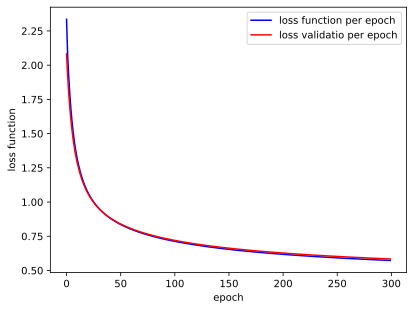

0.8104000091552734


In [ ]:
D_in = 784
D_out= 10

## -----------> Model <----------------
model = nn.Sequential(nn.Linear(D_in, D_out), nn.LogSoftmax(dim=1))
loss_function = nn.NLLLoss()

## -----------> generic training loop <----------------
Nepochs = 300
lr = 0.1 # Best learning rate found
sgd = th.optim.SGD(model.parameters(), lr = lr)
loss_t_rec = []
loss_v_rec = []

for epoch in range(Nepochs):
  ## ------- training ------
  Y_pred = model(Xtrain)
  loss_t = loss_function(Y_pred,Ytrain)
  loss_t_rec.append(loss_t.item())
  sgd.zero_grad()
  loss_t.backward()
  sgd.step()

  ## ------- validation ------
  Y_pred_v = model(Xvalid)
  loss_v = loss_function(Y_pred_v, Yvalid)
  loss_v_rec.append(loss_v.item())


print(loss_t)
print(loss_v)
plt.plot(loss_t_rec, 'b', label = "loss function per epoch")
plt.plot(loss_v_rec, 'r', label = "loss validatio per epoch")
plt.xlabel('epoch')
plt.ylabel('loss function')
plt.legend()
plt.show()

## ------- Accuracy ------
class_pred = th.argmax(Y_pred_v, dim = 1)
accuracy = th.where(class_pred == Yvalid, 1, 0)
prob = th.sum(accuracy)/accuracy.shape[0]
print(prob.item()) # Probability of rigth answer

Accuracy = 0.8105999827384949


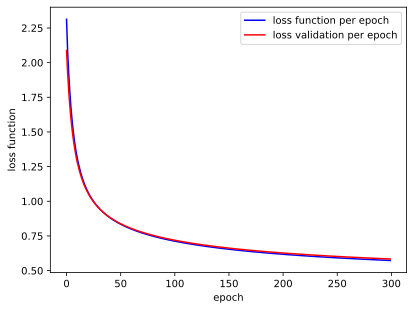

In [ ]:
## -----------> TODO: train function <----------------
def training (X, Y, Xv, Yv, model, loss_fn, lr, Nepochs): #(X training, Y traning, X validation, Y validation)
  sgd = th.optim.SGD(model.parameters(), lr = lr)
  loss_t_rec = []
  loss_v_rec = []

  ## -----------> generic training loop <----------------
  for epoch in range(Nepochs):
    ## ------- training ------
    Y_pred = model(X)
    loss_t = loss_fn(Y_pred,Y)
    loss_t_rec.append(loss_t.item())
    sgd.zero_grad()
    loss_t.backward()
    sgd.step()

    ## ------- validation ------
    Y_pred_v = model(Xv)
    loss_v = loss_fn(Y_pred_v, Yv)
    loss_v_rec.append(loss_v.item())

  ## ------- Accuracy ------
  class_pred = th.argmax(Y_pred_v, dim = 1)
  accuracy = th.where(class_pred == Yv, 1, 0)
  prob = th.sum(accuracy)/accuracy.shape[0]

  return loss_t_rec, loss_v_rec, prob.item()

##---------- TEST ---------------

NEPOCHS = 300
LR = 0.1

D_in = 784
D_out= 10

## -----------> Model <----------------
model = nn.Sequential(nn.Linear(D_in, D_out), nn.LogSoftmax(dim=1))
loss_function = nn.NLLLoss()

data_t, data_v, Prob = training(Xtrain, Ytrain, Xvalid, Yvalid, model, loss_function, LR, NEPOCHS)

print("Accuracy =", Prob)

plt.plot(data_t, 'b', label = "loss function per epoch")
plt.plot(data_v, 'r', label = "loss validation per epoch")
plt.xlabel('epoch')
plt.ylabel('loss function')
plt.legend()
plt.show()


## Neural Network with one hidden layer

Now we have a function to train a neural model and evaluate the training process. This is your starting point for exploration of **different network architectures**.

Your next architecture will be a network with:

    One hidden layer of size 50

    Sigmoid activation

Write the model using the **nn.Sequential** module, and train it:

- for 30 epochs with learning rates 0.001 and 0.0001
- for 50 epochs and the same learning rates
- What do you observe ? How do learning rates and number of epochs affect your results ?



Accuracy = 0.7768999934196472


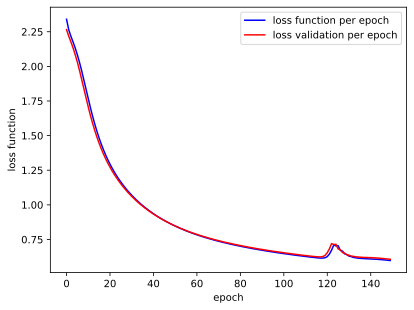

In [ ]:
## -----------> TODO <----------------
NEPOCHS = 150
LR = 0.8

D_in = 784
D_out1 = 50
D_out2 = 10

## -----------> Model sigmoid <----------------
model = nn.Sequential(nn.Linear(D_in, D_out1), nn.Sigmoid(), nn.Linear(D_out1, D_out2), nn.LogSoftmax(dim=1))
loss_function = nn.NLLLoss()

data_t, data_v, Prob = training(Xtrain, Ytrain, Xvalid, Yvalid, model, loss_function, LR, NEPOCHS)

print("Accuracy =", Prob)

plt.plot(data_t, 'b', label = "loss function per epoch")
plt.plot(data_v, 'r', label = "loss validation per epoch")
plt.xlabel('epoch')
plt.ylabel('loss function')
plt.legend()
plt.show()

## SGD with momentum

Up to now, you have trained your NNets using the SGD optimizer. This works fine but in general SGD can be slow to converge, especially when the loss surface has gorges with steep sides, i.e., regions where the gradient changes steeply in some directions and slowly in others. This can cause the optimization to zigzag and take longer to reach a minimum.

A way to overcome this problem is to use **momentum** -- a parameter in SGD optimizer that helps accelerate training, especially in tricky regions. Basically, instead of updating parameters purely based on the current gradient, we also consider the previous updates. This creates a sort of "velocity" that helps smooth out the path and push through small oscillations.

**Your task:**

- Add the moment term to the optimizer (try 0.9)
- See the impact on the training, with different values.

## From Sigmoid to ReLU activation

**Your task:**

- Consider lr=0.0001 and train your model with a ReLU activation.
- Compare the results to the Sigmoid.

In [ ]:
## -----------> TODO <----------------


## Impact of the hidden layer size

Run experiments with different hidden layer sizes.

    Try: 50,100,150,200 and 250.

- What do you observe ?


In [ ]:
## -----------> TODO <----------------


## Deeper network -- two hidden layers

Now we add one more hidden layer to our architecture.

To start with, consider:

    Two hidden layers of size 50

    Activation: ReLU
    
    Learning rate: 0.0001

    Train for 100 epochs
    

In [ ]:
## -----------> TODO <----------------


    Try different dropout values (e.g., 0.3, 0.5)
    
NB: When you apply dropout with a certain probability **p**, each neuron in a given layer has a chance **p** of being dropped during training. This forces the network to not rely too heavily on any single neuron, which improves generalization. The value 0.3 is used for mild regularization, i.e., when you have a small or simple network; 0.5 corresponds to stronger regularization and is a typically used for deeper or overfitting networks.       

In [ ]:
## -----------> TODO <----------------


Play with different hyperparameters:

    Larger hidden layers (double it for example)

    Adding a third hidden layer



In [ ]:
## -----------> TODO <----------------


## Add Batch Normalization

BatchNorm helps deeper networks train faster and more reliably.

**Your task:**

- Build a neural network with 2 hidden layers.
- Insert Batch Normalization block where it is useful.
- Train the model and compare the optimization speed.



In [ ]:
## -----------> TODO <----------------


## Online learning vs. mini-batch vs. full-batch training

In practice, it’s not always possible to train a model on the entire dataset at once — either due to memory limitations or the nature of the application (e.g., streaming data). This is where different training strategies come into play:


- Online Training (Stochastic Gradient Descent)

        - The model is updated one example at a time.

        - At each step, a single image is selected (often randomly), and the gradient is computed and used to update the model.

        - This introduces a lot of noise but can be useful when data arrives sequentially or memory is tight.

        - In theory converges faster, very fast per-step, but in practice not efficient in terms of computation time.
        


- Mini-Batch Training

        A middle ground: the training data is split into small batches of size B; the split changes at each epoch.

        The model is updated after computing the gradient on each batch.

        Offers a good trade-off between computational efficiency and gradient stability.

        Usually used in deep learning frameworks: it allows us a tradeoff in terms of memory requirement.
        
     

- Full-Batch Training

        The gradient is computed over the entire training set before each update.

        This produces the most accurate gradient estimate, but:

            Requires loading all the data at once.

            Can be very slow per update, especially for large datasets.


To fully explore different training strategies, compare them directly on your datatset.

**Your task:**

- Make a comparison in terms of computational efficiency to do one training epoch with: online, mini-batch (B=200) and full training.

- Then make a convergence speed comparison between these 3 training methods: how many epochs are needed to reach good performance ?

*NB: it is important to always adapt the learning rate to have nice performance!*



In [ ]:
## -----------> TODO <----------------



## Dropout layer to prevent overfitting -- in more details

Even though Fashion-MNIST is a relatively simple dataset, it is still very easy to overfit, especially with small models and limited regularization.

To remind you (you discussed this in TD) overfitting means:

    Your model performs well on the training set (from TD - the fitted curve went through all the datapoints),

    But performs poorly on unseen data (from TD - the curve would change if you added new data, i.e., the fit (model) cannot be generalized).

Dropout is a regularization technique that randomly **drops** a fraction of neurons during training (e.g., 20% with p=0.2). This forces the model to not rely too much on any one feature or path!

- During training dropout randomly sets activations to zero with probability p.

- During evaluation dropout turns off, and the full network is used.

In the section on Deeper networks above, you already played with the dropout option. When applied after a single hidden layer, it helps prevent overfitting in a shallow model. If, however, it is applied after each hidden layer in a deeper network, it is addressing overfitting across more complex representations, where the risk of memorization is higher.

**Your task:**

- Code this modification (with p=0.2), rerun the training process and compare the training curves.

As stated, when you use a Dropout layer, the layer acts differently in the train mode and evaluation mode. You should take this into account when you train the model and when you compute the performance on the validation set.


In [ ]:
## -----------> TODO <----------------


## Final Test

- Take two of your best models (among those with one and two hidden layers) and run the evaluation on the test set.
- Train the best two models with all the training data and compute the results on the test set.


In [ ]:
## -----------> TODO <----------------
